## Modeling using calculated descriptors, biomass features, and condition parameters

In [43]:
# # libraries to install
# ! pip install shap -q
# ! pip install lime -q
# ! pip install eli5 -q

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectPercentile, SelectKBest, SelectFromModel
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.covariance import EllipticEnvelope
import xgboost as xgb
import tqdm
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from statistics import mean, stdev
from functools import partial
from mlxtend.evaluate import bias_variance_decomp
from IPython.display import display
from mlxtend.evaluate import bias_variance_decomp
import shap
import lime
import lime.lime_tabular
from eli5 import show_prediction, show_weights
from eli5.sklearn import PermutationImportance

In [4]:
SEED = 7

random.seed(SEED)
np.random.seed(SEED)

In [5]:
# input file could be obtained by running note1.ipynb and saving calculated descriptors to csv
# alternatively data from ESI Table S4 can be used (preprocessing will be done in the same way but not relevant since S4 contains already preprocessed data)

df_orig = pd.read_csv('./lignin-data-with-descs.csv', sep=';')
if 'Unnamed: 0' in df_orig.columns: df_orig.drop(['Unnamed: 0'], axis=1, inplace=True) # dropping index if left
df_orig[['smiles_cat', 'smiles_ani']] = df_orig['smiles'].str.split('.', expand=True)
df = df_orig.drop(['smiles', 'smiles_cat', 'smiles_ani'], axis=1, inplace=False)

descriptors_to_use = [
    'mordred',
    # 'fingerprints',
]

biomass_features_to_use = [
    # 'feed_material',
    # 'perc_cellulose',
    'perc_hemicellulose',
    # 'perc_lignins'
]

conditions_features_to_use = [
    'il_conc',
    'temp',
    'time'
]

separate_conditions_and_biomass = True
check_correlations_on_conditional_features = False
descritize_time = False
correlation_on_ils_set = True
remove_multicorrelated_flag = True
remove_correlated_flag = True
reduce_descritpors_number_flag = True
var_thres_flag = False
user_assisted_flag = False
find_optimal_k_flag = False

if reduce_descritpors_number_flag and not find_optimal_k_flag:
    if biomass_features_to_use == ['perc_hemicellulose'] and descriptors_to_use == ['mordred'] and user_assisted_flag == False: k_feature_number = 8
    if biomass_features_to_use == ['perc_hemicellulose'] and descriptors_to_use == ['mordred'] and user_assisted_flag == True: k_feature_number = 10
    if biomass_features_to_use == ['perc_hemicellulose'] and descriptors_to_use == ['fingerprints'] and user_assisted_flag == False: k_feature_number = 23
    if biomass_features_to_use == ['perc_hemicellulose'] and descriptors_to_use == ['fingerprints'] and user_assisted_flag == True: k_feature_number = 9
    if biomass_features_to_use == ['perc_hemicellulose'] and descriptors_to_use == ['mordred', 'fingerprints'] and user_assisted_flag == False: k_feature_number = 20
    if biomass_features_to_use == ['perc_hemicellulose'] and descriptors_to_use == ['mordred', 'fingerprints'] and user_assisted_flag == True: k_feature_number = 10

    if biomass_features_to_use == ['perc_hemicellulose', 'perc_lignins'] and descriptors_to_use == ['mordred'] and user_assisted_flag == False: k_feature_number = 9
    if biomass_features_to_use == ['perc_hemicellulose', 'perc_lignins'] and descriptors_to_use == ['mordred'] and user_assisted_flag == True: k_feature_number = 11
    if biomass_features_to_use == ['perc_hemicellulose', 'perc_lignins'] and descriptors_to_use == ['fingerprints'] and user_assisted_flag == False: k_feature_number = None
    if biomass_features_to_use == ['perc_hemicellulose', 'perc_lignins'] and descriptors_to_use == ['fingerprints'] and user_assisted_flag == True: k_feature_number = None
    if biomass_features_to_use == ['perc_hemicellulose', 'perc_lignins'] and descriptors_to_use == ['mordred', 'fingerprints'] and user_assisted_flag == False: k_feature_number = None
    if biomass_features_to_use == ['perc_hemicellulose', 'perc_lignins'] and descriptors_to_use == ['mordred', 'fingerprints'] and user_assisted_flag == True: k_feature_number = None

    if biomass_features_to_use == ['perc_lignins'] and descriptors_to_use == ['mordred'] and user_assisted_flag == False: k_feature_number = 9

outlier_detection_method = ['isolation_forest', 0.05]

# remove unused features
if 'mordred' not in descriptors_to_use: df.drop(list(df.filter(regex='_mordred_')), axis=1, inplace=True)
if 'padel' not in descriptors_to_use: df.drop(list(df.filter(regex='_padel_')), axis=1, inplace=True)
if 'fingerprints' not in descriptors_to_use: df.drop(list(df.filter(regex='_fp_')), axis=1, inplace=True)
if 'spectrophores' not in descriptors_to_use: df.drop(list(df.filter(regex='_spectro_')), axis=1, inplace=True)

if 'feed_material' not in biomass_features_to_use: df.drop(['feed_material'], axis=1, inplace=True)
if 'perc_cellulose' not in biomass_features_to_use: df.drop(['perc_cellulose'], axis=1, inplace=True)
if 'perc_hemicellulose' not in biomass_features_to_use: df.drop(['perc_hemicellulose'], axis=1, inplace=True)
if 'perc_lignins' not in biomass_features_to_use: df.drop(['perc_lignins'], axis=1, inplace=True)

if 'il_conc' not in conditions_features_to_use: df.drop(['il_conc'], axis=1, inplace=True)
if 'temp' not in conditions_features_to_use: df.drop(['temp'], axis=1, inplace=True)
if 'time' not in conditions_features_to_use: df.drop(['time'], axis=1, inplace=True)
elif descritize_time:
    df.loc[df['time'] < 10, 'time'] = 0
    df.loc[df['time'] >= 10, 'time'] = 1

df.drop_duplicates(inplace=True)
df

,perc_hemicellulose,il_conc,temp,time,yield,c_mordred_ABC,c_mordred_ABCGG,c_mordred_nAcid,c_mordred_nBase,c_mordred_SpAbs_A,...,a_mordred_SRW10,a_mordred_TSRW10,a_mordred_MW,a_mordred_AMW,a_mordred_WPath,a_mordred_WPol,a_mordred_Zagreb1,a_mordred_Zagreb2,a_mordred_mZagreb1,a_mordred_mZagreb2
0,19.80,1.0,90,24.000000,60.4,4.719397,5.004088,0,1,6.720566,...,8.168770,37.326413,145.098251,6.308620,143,9,38.0,38.0,5.222222222222222,2.527778
1,19.80,1.0,90,24.000000,59.9,4.719397,5.004088,0,1,6.720566,...,6.834109,27.254130,74.024752,8.224972,18,2,16.0,14.0,3.361111111111111,1.333333
2,19.80,1.0,90,24.000000,58.3,4.719397,5.004088,0,1,6.720566,...,7.626083,30.698690,88.040402,7.336700,29,4,22.0,21.0,4.222222222222222,1.444444
3,19.80,1.0,90,24.000000,54.7,4.719397,5.004088,0,1,6.720566,...,7.890957,32.688753,104.035317,8.002717,46,6,26.0,26.0,4.472222222222222,1.777778
4,19.80,1.0,90,24.000000,53.1,4.719397,5.004088,0,1,6.720566,...,8.297793,35.071670,118.050967,7.378185,65,8,32.0,33.0,5.333333333333334,1.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,31.58,1.0,185,0.083333,60.4,5.766244,5.909452,0,1,9.910095,...,6.188264,24.179697,59.013853,8.430550,9,0,12.0,9.0,3.111111111111111,1.000000
105,31.58,1.0,185,0.250000,79.3,5.766244,5.909452,0,1,9.910095,...,6.188264,24.179697,59.013853,8.430550,9,0,12.0,9.0,3.111111111111111,1.000000
106,21.90,0.1,140,1.000000,32.7,4.719397,5.004088,0,1,6.720566,...,8.168770,37.326413,145.098251,6.308620,143,9,38.0,38.0,5.222222222222222,2.527778
107,22.70,0.1,140,1.000000,47.2,4.719397,5.004088,0,1,6.720566,...,8.168770,37.326413,145.098251,6.308620,143,9,38.0,38.0,5.222222222222222,2.527778


In [6]:
def check_nans(df):
    print('Checking for nans:', end = ' ')
    examples = []
    number_of_nans = 0
    for col in df.columns:
        if df[col].isnull().sum()>0:
            number_of_nans += 1
            if number_of_nans < 5:
                examples.append(f"{col} : {df[col].isnull().sum()}")
    print(f"number of columns with nans = {number_of_nans}, for example: {examples}")
check_nans(df)
df = df.apply(pd.to_numeric, errors='coerce')
check_nans(df)
df = df.dropna(axis=1, how='all') # drop columns with only nans
check_nans(df)
df = df.dropna(axis=1, thresh=2)
check_nans(df)

for col in df.columns:
    if df[col].isnull().sum()>0:
        df[col]=df[col].fillna(df[col].mean())

print('\nCleaned data by replacing nans with means')
check_nans(df)

Checking for nans: number of columns with nans = 0, for example: []
Checking for nans: number of columns with nans = 974, for example: ['c_mordred_AATS6dv : 1', 'c_mordred_AATS7dv : 28', 'c_mordred_AATS8dv : 75', 'c_mordred_AATS6d : 1']
Checking for nans: number of columns with nans = 670, for example: ['c_mordred_AATS6dv : 1', 'c_mordred_AATS7dv : 28', 'c_mordred_AATS8dv : 75', 'c_mordred_AATS6d : 1']
Checking for nans: number of columns with nans = 654, for example: ['c_mordred_AATS6dv : 1', 'c_mordred_AATS7dv : 28', 'c_mordred_AATS8dv : 75', 'c_mordred_AATS6d : 1']

Cleaned data by replacing nans with means
Checking for nans: number of columns with nans = 0, for example: []


In [7]:
# check if all columns in df are numeric
numeric_lst = ['uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(df.select_dtypes(include = numeric_lst).columns)
print(len(numeric_cols))
print(df.shape)

# print columns that are not numeric
non_numeric_cols = [col for col in df.columns if col not in numeric_cols]
print(non_numeric_cols)

# drop not numeric columns
df = df.drop(non_numeric_cols,axis=1)
print(df.shape)
df.head()

2907
(109, 2911)
['c_mordred_Lipinski', 'c_mordred_GhoseFilter', 'a_mordred_Lipinski', 'a_mordred_GhoseFilter']
(109, 2907)


,perc_hemicellulose,il_conc,temp,time,yield,c_mordred_ABC,c_mordred_ABCGG,c_mordred_nAcid,c_mordred_nBase,c_mordred_SpAbs_A,...,a_mordred_SRW10,a_mordred_TSRW10,a_mordred_MW,a_mordred_AMW,a_mordred_WPath,a_mordred_WPol,a_mordred_Zagreb1,a_mordred_Zagreb2,a_mordred_mZagreb1,a_mordred_mZagreb2
0,19.8,1.0,90,24.0,60.4,4.719397,5.004088,0,1,6.720566,...,8.168770,37.326413,145.098251,6.308620,143,9,38.0,38.0,5.222222,2.527778
1,19.8,1.0,90,24.0,59.9,4.719397,5.004088,0,1,6.720566,...,6.834109,27.254130,74.024752,8.224972,18,2,16.0,14.0,3.361111,1.333333
2,19.8,1.0,90,24.0,58.3,4.719397,5.004088,0,1,6.720566,...,7.626083,30.698690,88.040402,7.336700,29,4,22.0,21.0,4.222222,1.444444
3,19.8,1.0,90,24.0,54.7,4.719397,5.004088,0,1,6.720566,...,7.890957,32.688753,104.035317,8.002717,46,6,26.0,26.0,4.472222,1.777778
4,19.8,1.0,90,24.0,53.1,4.719397,5.004088,0,1,6.720566,...,8.297793,35.071670,118.050967,7.378185,65,8,32.0,33.0,5.333333,1.888889


In [8]:
if separate_conditions_and_biomass:
    conditions_params = [*biomass_features_to_use, *conditions_features_to_use]
    X_orig = df.drop(labels = ['yield', *conditions_params], axis=1)
    df_conditions_params = df[conditions_params]
    df_conditions_params = ( df_conditions_params - df_conditions_params.min() ) / ( df_conditions_params.max() - df_conditions_params.min() )
else:
    X_orig = df.drop(labels = ['yield'], axis=1)
y_orig = df['yield']

In [9]:
if user_assisted_flag:
    selected_columns = [
            # descriptors
            'c_mordred_MW', 'a_mordred_MW',
            'c_mordred_TopoPSA', 'a_mordred_TopoPSA',
            'c_mordred_nHBDon', 'a_mordred_nHBAcc',
            'c_mordred_SlogP_VSA1', 'a_mordred_SlogP_VSA1',
            'c_mordred_nAromAtom', 'a_mordred_nAromAtom',
            'c_mordred_nRot', 'a_mordred_nRot',
            # fingerprints
            'a_fp_452', 'a_fp_202', 'a_fp_330', 'a_fp_429', 'a_fp_147', 'c_fp_77', 'c_fp_222', 'c_fp_375'
            ]
    selected_columns = df.columns.intersection(selected_columns).values
    X_orig = X_orig[selected_columns]

In [10]:
# drop constant features
constant_vars = [col for col in list(X_orig) if len(X_orig[col].value_counts()) == 1]
X_orig.drop(constant_vars,axis = 1, inplace = True)
check_nans(X_orig)

X_orig = ( X_orig - X_orig.min() ) / ( X_orig.max() - X_orig.min() )
y_orig = y_orig / 100

check_nans(X_orig)

if var_thres_flag:
    var_thres = VarianceThreshold(threshold=0.05)
    if correlation_on_ils_set:
        var_thres.fit(X_orig.drop_duplicates(inplace=False))
    else:
        var_thres.fit(X_orig)
    print(f'{sum(var_thres.get_support()) = }')
    X_orig = X_orig.iloc[:, var_thres.get_support()]
    print(f"Set shape: {X_orig.shape}, {y_orig.shape}")

    if separate_conditions_and_biomass and check_correlations_on_conditional_features:
        var_thres = VarianceThreshold(threshold=0.05)
        var_thres.fit(df_conditions_params)
        df_conditions_params = df_conditions_params.iloc[:, var_thres.get_support()]

Checking for nans: number of columns with nans = 0, for example: []
Checking for nans: number of columns with nans = 0, for example: []


In [11]:
def remove_correlated(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

# remove duplicated columns (by values)
X_orig = X_orig.T.drop_duplicates().T

# remove correlated features
if remove_correlated_flag:
    if 'fingerprints' in descriptors_to_use:
        if correlation_on_ils_set:
            corr_features = remove_correlated(X_orig.drop_duplicates(inplace=False).drop(list(X_orig.filter(regex='_fp_')), axis=1, inplace=False), 0.9)
        else:
            corr_features = remove_correlated(X_orig.drop(list(X_orig.filter(regex='_fp_')), axis=1, inplace=False), 0.9)
    else:
        if correlation_on_ils_set:
            corr_features = remove_correlated(X_orig.drop_duplicates(inplace=False), 0.9)
        else:
            corr_features = remove_correlated(X_orig, 0.9)
    print(f'{len(set(corr_features)) = }')
    X_orig = X_orig.drop(corr_features,axis=1)
    print(f"Set shape: {X_orig.shape}, {y_orig.shape}")

    if separate_conditions_and_biomass and check_correlations_on_conditional_features:
        corr_features_process = remove_correlated(df_conditions_params.drop(list(df_conditions_params.filter(regex='_fp_')), axis=1, inplace=False), 0.9)
        df_conditions_params = df_conditions_params.drop(corr_features_process,axis=1)
        print(f"Dropping {corr_features_process = }")

len(set(corr_features)) = 1844
Set shape: (109, 342), (109,)


In [12]:
def calculate_vif(X_train, thresh=5.0):
    variables_to_drop = []
    X = X_train.assign(const=1)
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        vif = vif[:-1]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            variables_to_drop.append(variables[maxloc])
            del variables[maxloc]
            dropped = True

    return X.columns[variables[:-1]]

def remove_multicorrelated(X_train, X_test = None):
    nonmulticolinear_features = calculate_vif(X_train = X_train, thresh = 10)
    print(f'{nonmulticolinear_features = }')
    print(f'{X_train.shape[1] = }')
    for column in X_train:
      if column not in nonmulticolinear_features:
        print(f'Dropping column: {column}')
    X_train = X_train[X_train.columns.intersection(nonmulticolinear_features)]
    if X_test is not None: X_test = X_test[X_train.columns.intersection(nonmulticolinear_features)]
    print(f'{X_train.shape[1] = }')
    return X_train

if remove_multicorrelated_flag:
    if 'fingerprints' in descriptors_to_use:
        if correlation_on_ils_set:
            nonmulticolinear_features = calculate_vif(X_orig.drop_duplicates(inplace=False).drop(list(X_orig.filter(regex='_fp_')), axis=1, inplace=False))
            X_orig_non_colinear = X_orig[nonmulticolinear_features]
            X_orig = pd.concat([X_orig[list(X_orig.filter(regex='_fp_'))], X_orig_non_colinear], axis=1)
        else:
            X_orig_non_colinear = remove_multicorrelated(X_orig.drop(list(X_orig.filter(regex='_fp_')), axis=1, inplace=False))
            X_orig = pd.concat([X_orig[list(X_orig.filter(regex='_fp_'))], X_orig_non_colinear], axis=1)
    else:
        if correlation_on_ils_set:
            nonmulticolinear_features = calculate_vif(X_orig.drop_duplicates(inplace=False))
            X_orig = X_orig[nonmulticolinear_features]
        else:
            X_orig = remove_multicorrelated(X_orig)

    if separate_conditions_and_biomass and check_correlations_on_conditional_features:
        df_conditions_params = remove_multicorrelated(df_conditions_params)

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


In [13]:
if separate_conditions_and_biomass:
    X_all = pd.concat([X_orig, df_conditions_params], axis=1)
else:
    X_all = X_orig.copy()

In [14]:
print(f'Before outlier removal: {X_all.shape = }')
if outlier_detection_method[1] != 0:
    if outlier_detection_method[0] == 'isolation_forest': ifod = IsolationForest(contamination=outlier_detection_method[1], n_estimators=100, random_state=SEED).fit(X_all, y_orig)
    if outlier_detection_method[0] == 'eliptic_envelope': ifod = EllipticEnvelope(contamination=outlier_detection_method[1], random_state=SEED).fit(X_all, y_orig)
    y = y_orig[ifod.predict(X_all) == 1]
    X = X_all[ifod.predict(X_all) == 1]


    # drop constant features
    constant_vars = [col for col in list(X) if len(X[col].value_counts()) == 1]
    X.drop(constant_vars,axis = 1, inplace = True)

    print(f'After outlier removal: {X.shape = }')
else:
    X = X_all
    y = y_orig

Before outlier removal: X_all.shape = (109, 23)
After outlier removal: X.shape = (103, 23)


X does not have valid feature names, but IsolationForest was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
print(f"{descriptors_to_use = }, {biomass_features_to_use = }, {conditions_features_to_use = }, {outlier_detection_method = }, {remove_multicorrelated_flag = }, {remove_correlated_flag = }, {reduce_descritpors_number_flag = }")

final_eval_ks_gb = {}
final_eval_ks_rf = {}

if find_optimal_k_flag: k_features_range = range(2, min(16, X.shape[1]+1))
else: k_features_range = [k_feature_number]

for k_features in k_features_range:
    r2s_train_gb_final, r2s_valid_gb_final, r2s_test_gb_final = [], [], []
    maes_train_gb_final, maes_valid_gb_final, maes_test_gb_final = [], [], []
    mses_train_gb_final, mses_valid_gb_final, mses_test_gb_final = [], [], []
    loss_gb, bias_gb, var_gb = [], [], []
    r2s_train_rf_final, r2s_valid_rf_final, r2s_test_rf_final = [], [], []
    maes_train_rf_final, maes_valid_rf_final, maes_test_rf_final = [], [], []
    mses_train_rf_final, mses_valid_rf_final, mses_test_rf_final = [], [], []
    loss_rf, bias_rf, var_rf = [], [], []

    if reduce_descritpors_number_flag:
        scoring_func = partial(mutual_info_regression, random_state=SEED) # mutual_info_regression
        selected_top_columns = SelectKBest(scoring_func, k=k_features)
        selected_top_columns.fit(X, y)

    seeds_array = [1231, 8172, 3990, 6973]
    for seedi, seed in enumerate(seeds_array):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = seed)

        if reduce_descritpors_number_flag:
            X_train = X_train.loc[:, selected_top_columns.get_support()]
            X_test = X_test.loc[:, selected_top_columns.get_support()]

        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        r2s_train_gb, r2s_valid_gb = [], []
        maes_train_gb, maes_valid_gb = [], []
        mses_train_gb, mses_valid_gb = [], []
        r2s_train_rf, r2s_valid_rf = [], []
        maes_train_rf, maes_valid_rf = [], []
        mses_train_rf, mses_valid_rf = [], []

        for i, (train_index, test_index) in enumerate(kf.split(X_train)):
            X_subset_train, y_subset_train = X_train.iloc[train_index].astype(float), y_train.iloc[train_index].astype(float)
            X_subset_valid, y_subset_valid = X_train.iloc[test_index].astype(float), y_train.iloc[test_index].astype(float)

            # gradient boosting
            model_xgb = xgb.XGBRegressor(objective="reg:squarederror",
                                        random_state=SEED)
            model_xgb.fit(X_subset_train, y_subset_train)

            r2s_train_gb.append(r2_score(y_subset_train, model_xgb.predict(X_subset_train)))
            r2s_valid_gb.append(r2_score(y_subset_valid, model_xgb.predict(X_subset_valid)))
            maes_train_gb.append(mean_absolute_error(y_subset_train, model_xgb.predict(X_subset_train)))
            maes_valid_gb.append(mean_absolute_error(y_subset_valid, model_xgb.predict(X_subset_valid)))
            mses_train_gb.append(mean_squared_error(y_subset_train, model_xgb.predict(X_subset_train)))
            mses_valid_gb.append(mean_squared_error(y_subset_valid, model_xgb.predict(X_subset_valid)))

            # random forest
            model_rf = RandomForestRegressor(n_estimators = 5000,
                                            max_depth = 4,
                                            random_state=SEED)
            model_rf.fit(X_subset_train, y_subset_train)

            r2s_train_rf.append(r2_score(y_subset_train, model_rf.predict(X_subset_train)))
            r2s_valid_rf.append(r2_score(y_subset_valid, model_rf.predict(X_subset_valid)))
            maes_train_rf.append(mean_absolute_error(y_subset_train, model_rf.predict(X_subset_train)))
            maes_valid_rf.append(mean_absolute_error(y_subset_valid, model_rf.predict(X_subset_valid)))
            mses_train_rf.append(mean_squared_error(y_subset_train, model_rf.predict(X_subset_train)))
            mses_valid_rf.append(mean_squared_error(y_subset_valid, model_rf.predict(X_subset_valid)))

        # gradient boosting final summary and evaluation
        model_xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=SEED)
        model_xgb.fit(X_train, y_train)
        r2s_test_gb = r2_score(y_test, model_xgb.predict(X_test))
        maes_test_gb = mean_absolute_error(y_test, model_xgb.predict(X_test))
        mses_test_gb = mean_squared_error(y_test, model_xgb.predict(X_test))
        exp_loss_gb, exp_bias_gb, exp_var_gb = bias_variance_decomp(model_xgb, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=50, random_seed=SEED)
        loss_gb.append(exp_loss_gb)
        bias_gb.append(exp_bias_gb)
        var_gb.append(exp_var_gb)

        # random forest final summary and evaluation
        model_rf = RandomForestRegressor(n_estimators = 5000,
                                        max_depth = 4,
                                        random_state=SEED)
        model_rf.fit(X_train, y_train)
        r2s_test_rf = r2_score(y_test, model_rf.predict(X_test))
        maes_test_rf = mean_absolute_error(y_test, model_rf.predict(X_test))
        mses_test_rf = mean_squared_error(y_test, model_rf.predict(X_test))
        exp_loss_rf, exp_bias_rf, exp_var_rf = bias_variance_decomp(model_rf, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=50, random_seed=SEED)
        loss_rf.append(exp_loss_rf)
        bias_rf.append(exp_bias_rf)
        var_rf.append(exp_var_rf)

        # R2
        r2s_train_gb_final.append(mean(r2s_train_gb))
        r2s_train_rf_final.append(mean(r2s_train_rf))

        r2s_valid_gb_final.append(mean(r2s_valid_gb))
        r2s_valid_rf_final.append(mean(r2s_valid_rf))

        r2s_test_gb_final.append(r2s_test_gb)
        r2s_test_rf_final.append(r2s_test_rf)

        # MAE
        maes_train_gb_final.append(mean(maes_train_gb))
        maes_train_rf_final.append(mean(maes_train_rf))

        maes_valid_gb_final.append(mean(maes_valid_gb))
        maes_valid_rf_final.append(mean(maes_valid_rf))

        maes_test_gb_final.append(maes_test_gb)
        maes_test_rf_final.append(maes_test_rf)

        # MSE
        mses_train_gb_final.append(mean(mses_train_gb))
        mses_train_rf_final.append(mean(mses_train_rf))

        mses_valid_gb_final.append(mean(mses_valid_gb))
        mses_valid_rf_final.append(mean(mses_valid_rf))

        mses_test_gb_final.append(mses_test_gb)
        mses_test_rf_final.append(mses_test_rf)

    # print summary
    print(f'\n{k_features = }: {list(X_train.columns) = } \n \n')
    print(f'''GB model:
                R2 train = {mean(r2s_train_gb_final):.3f},
                R2 valid = {mean(r2s_valid_gb_final):.3f},
                R2 test  = {mean(r2s_test_gb_final):.3f}

                MAE train = {mean(maes_train_gb_final):.3f},
                MAE valid = {mean(maes_valid_gb_final):.3f},
                MAE test  = {mean(maes_test_gb_final):.3f}

                MSE train = {mean(mses_train_gb_final):.3f},
                MSE valid = {mean(mses_valid_gb_final):.3f},
                MSE test  = {mean(mses_test_gb_final):.3f}

                AVG loss = {mean(loss_gb):.3f},
                bias     = {mean(bias_gb):.3f},
                variance = {mean(var_gb):.3f}
                ''')
    print(f'''RF model:
                R2 train = {mean(r2s_train_rf_final):.3f},
                R2 valid = {mean(r2s_valid_rf_final):.3f},
                R2 test  = {mean(r2s_test_rf_final):.3f}

                MAE train = {mean(maes_train_rf_final):.3f},
                MAE valid = {mean(maes_valid_rf_final):.3f},
                MAE test  = {mean(maes_test_rf_final):.3f}

                MSE train = {mean(mses_train_rf_final):.3f},
                MSE valid = {mean(mses_valid_rf_final):.3f},
                MSE test  = {mean(mses_test_rf_final):.3f}

                AVG loss = {mean(loss_rf):.3f},
                bias     = {mean(bias_rf):.3f},
                variance = {mean(var_rf):.3f}
          ''')

    final_eval_ks_gb[k_features] = [mean(r2s_train_gb_final), mean(r2s_valid_gb_final), mean(r2s_test_gb_final)]
    final_eval_ks_rf[k_features] = [mean(r2s_train_rf_final), mean(r2s_valid_rf_final), mean(r2s_test_rf_final)]

descriptors_to_use = ['mordred'], biomass_features_to_use = ['perc_hemicellulose'], conditions_features_to_use = ['il_conc', 'temp', 'time'], outlier_detection_method = ['isolation_forest', 0.05], remove_multicorrelated_flag = True, remove_correlated_flag = True, reduce_descritpors_number_flag = True

k_features = 8: list(X_train.columns) = ['c_mordred_AATSC3i', 'c_mordred_MATS3pe', 'c_mordred_AXp-5d', 'a_mordred_MDEO-11', 'perc_hemicellulose', 'il_conc', 'temp', 'time'] 
 

GB model:
                R2 train = 0.982,
                R2 valid = 0.687,
                R2 test  = 0.768

                MAE train = 0.012,
                MAE valid = 0.108,
                MAE test  = 0.090

                MSE train = 0.001,
                MSE valid = 0.022,
                MSE test  = 0.014

                AVG loss = 0.022,
                bias     = 0.014,
                variance = 0.008
                
RF model:
                R2 train = 0.880,
                R2 valid = 0.629,
  

In [16]:
df_sensitivity = df[selected_top_columns.feature_names_in_].copy()
df_sensitivity['yield'] = df['yield']
yield_correlations = df_sensitivity.corr()['yield']
sensitivity_mutual = {}
for i, j in zip(selected_top_columns.feature_names_in_, selected_top_columns.scores_):
  k = yield_correlations[i]
  sensitivity_mutual[i] = [j, k]
sensitivity_mutual_df = pd.DataFrame.from_dict(sensitivity_mutual, orient='index', columns=['mutual_info_score', 'correlation_with_yield'])
sensitivity_mutual_df.sort_values(by='mutual_info_score', inplace=True, ascending=False)
sensitivity_mutual_df

,mutual_info_score,correlation_with_yield
perc_hemicellulose,0.450970,0.487522
il_conc,0.352463,-0.154742
temp,0.340623,0.420707
c_mordred_MATS3pe,0.330845,-0.333033
c_mordred_AATSC3i,0.311652,0.053219
c_mordred_AXp-5d,0.264446,-0.000877
a_mordred_MDEO-11,0.160824,0.287388
time,0.114292,0.109451
c_mordred_nHBAcc,0.112053,0.267868
a_mordred_mZagreb1,0.108825,-0.080470


In [17]:
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=SEED)
model_xgb.fit(X_train, y_train)

xgb_importances = {}
for i, j in zip(model_xgb.feature_names_in_, model_xgb.feature_importances_):
  xgb_importances[i] = [j]
xgb_importances_df = pd.DataFrame.from_dict(xgb_importances, orient='index', columns=['xgb_score'])
xgb_importances_df.sort_values(by='xgb_score', inplace=True, ascending=False)
xgb_importances_df

,xgb_score
perc_hemicellulose,0.295672
a_mordred_MDEO-11,0.166713
time,0.165769
temp,0.106943
il_conc,0.097076
c_mordred_AATSC3i,0.083634
c_mordred_MATS3pe,0.082620
c_mordred_AXp-5d,0.001574


In [18]:
perm = PermutationImportance(model_xgb,
                             n_iter = 100,
                             random_state = 6973,
                             ).fit(X_train, y_train)
show_weights(perm, feature_names=X_train.columns.values)

Weight,Feature
0.5264 ± 0.1560,perc_hemicellulose
0.4719 ± 0.1327,time
0.3822 ± 0.0954,temp
0.3311 ± 0.1240,il_conc
0.1927 ± 0.0817,c_mordred_AATSC3i
0.1674 ± 0.0782,a_mordred_MDEO-11
0.0326 ± 0.0136,c_mordred_MATS3pe
0.0003 ± 0.0001,c_mordred_AXp-5d


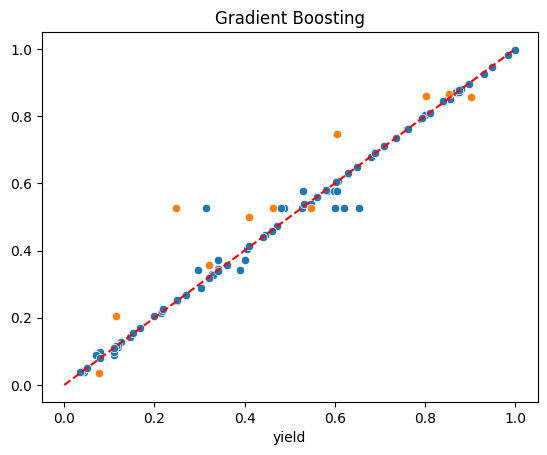

X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names


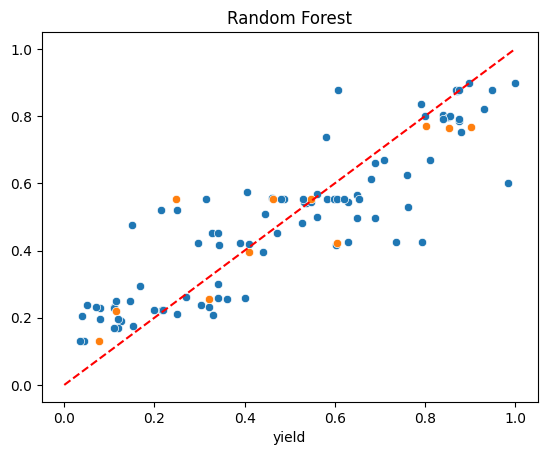

In [19]:
y_pred = model_xgb.predict(X_train)
y_pred_test = model_xgb.predict(X_test)
sns.scatterplot(x=y_train, y=y_pred)
sns.scatterplot(x=y_test, y=y_pred_test)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title(f'Gradient Boosting')
plt.show()

y_pred = model_rf.predict(X_train)
y_pred_test = model_rf.predict(X_test)
sns.scatterplot(x=y_train, y=y_pred)
sns.scatterplot(x=y_test, y=y_pred_test)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title(f'Random Forest')
plt.show()

In [20]:
if find_optimal_k_flag:
    plt.plot(k_features_range, [final_eval_ks_gb[key][0] for key in final_eval_ks_gb], label='train')
    plt.plot(k_features_range, [final_eval_ks_gb[key][1] for key in final_eval_ks_gb], label='valid')
    plt.plot(k_features_range, [final_eval_ks_gb[key][2] for key in final_eval_ks_gb], label='test')
    plt.legend()
    plt.show()
    test_array_diffks = [final_eval_ks_gb[key][1] for key in final_eval_ks_gb]
    valid_max_index = test_array_diffks.index(max(test_array_diffks))
    print(f"{valid_max_index = }")
    print(f"{final_eval_ks_gb[valid_max_index + k_features_range[0]] = }")

## Model interpretation

GRADIENT BOOSTING


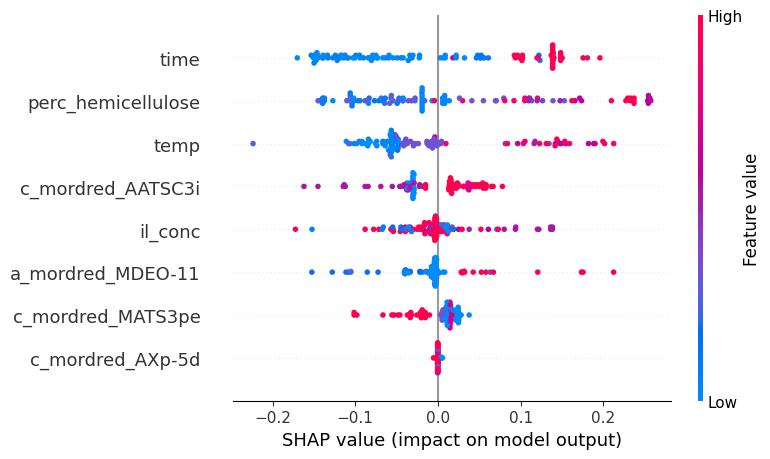

RANDOM FOREST


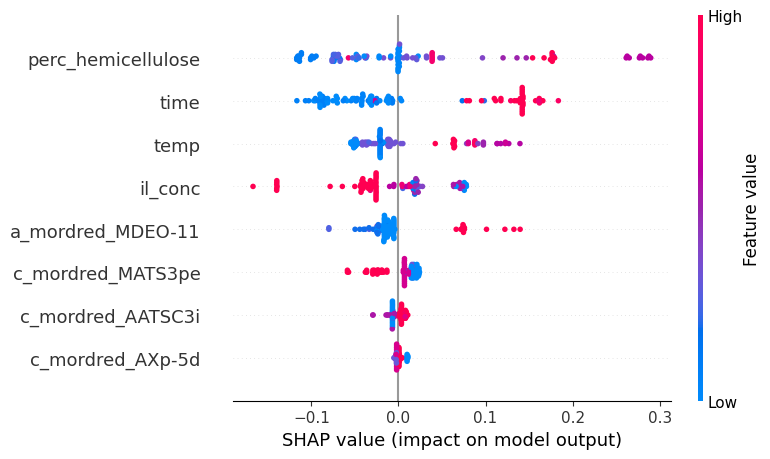

In [21]:
X_subset_for_inter = X.loc[:, selected_top_columns.get_support()]
print(f'GRADIENT BOOSTING')
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_subset_for_inter)
shap.summary_plot(shap_values, X_subset_for_inter)
print(f'RANDOM FOREST')
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer(X_subset_for_inter)
shap.summary_plot(shap_values, X_subset_for_inter)

In [22]:
print(f'GRADIENT BOOSTING')

X_subset_for_inter_interactive = X_all.loc[:, selected_top_columns.get_support()]

shap.plots.initjs()

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_subset_for_inter_interactive)

shap.force_plot(shap_values, X_subset_for_inter_interactive)

GRADIENT BOOSTING


In [23]:
df_orig.iloc[3, :]

feed_material                            3
perc_cellulose                        37.7
perc_hemicellulose                    19.8
perc_lignins                         18.25
il_conc                                1.0
                              ...         
a_padel_Vs                        8.069919
a_padel_Ks                        0.337937
a_padel_Ds                        1.307688
smiles_cat                  OCC[N+](C)(C)C
smiles_ani            N[C@@H](CO)C(=O)[O-]
Name: 3, Length: 8107, dtype: object

In [24]:
y.sort_values()

65    0.034
14    0.040
66    0.044
23    0.050
19    0.070
      ...  
46    0.903
79    0.930
93    0.949
59    0.985
96    1.000
Name: yield, Length: 103, dtype: float64

GRADIENT BOOSTING 65: TRUE  = 0.034, PRED = 0.20364883542060852
Intercept 0.4905210541844854
Prediction_local [0.22099948]
Right: 0.20364884


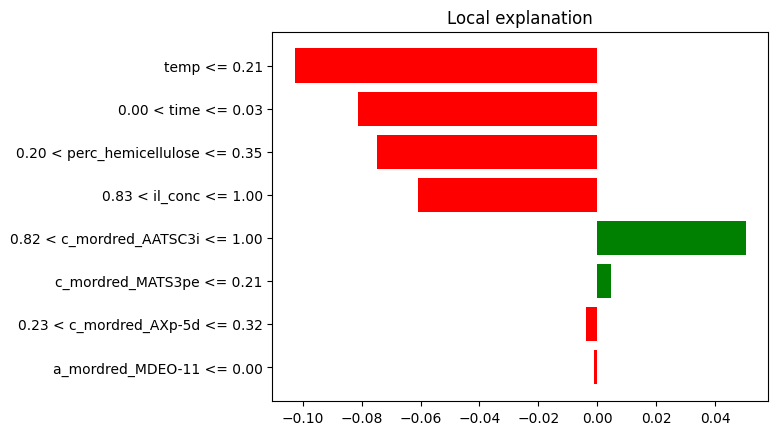

RANDOM FOREST 65: TRUE  = 0.034, PRED = 0.21921405446175882
Intercept 0.5410063255074643
Prediction_local [0.25101101]
Right: 0.21921405446175882


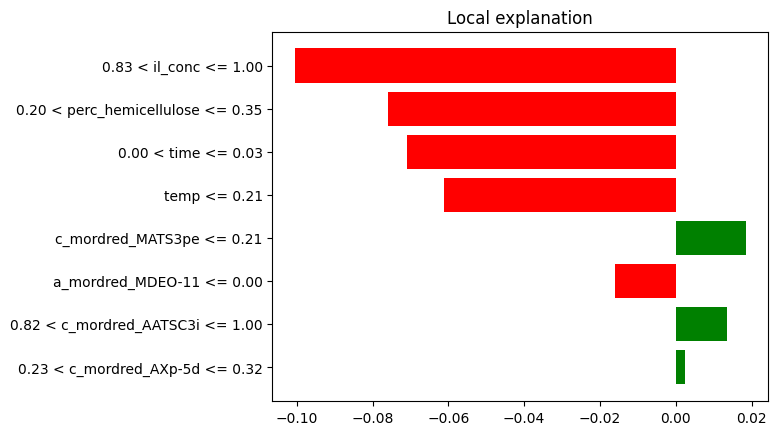

In [25]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_subset_for_inter.values,
                                                   feature_names=list(X_subset_for_inter.columns),
                                                   class_names=['yield'], verbose=True, mode='regression')
example_number = 65 # 52

print(f'GRADIENT BOOSTING {example_number}: TRUE  = {y[example_number]}, PRED = {model_xgb.predict(X_subset_for_inter.values[example_number, :].reshape(1, -1))[0]}')
exp = explainer.explain_instance(X_subset_for_inter.values[example_number], model_xgb.predict, num_features=len(list(X_subset_for_inter.columns))) #TODO explain for test set
exp.as_pyplot_figure()
plt.show()
print(f'RANDOM FOREST {example_number}: TRUE  = {y[example_number]}, PRED = {model_rf.predict(X_subset_for_inter.values[example_number, :].reshape(1, -1))[0]}')
exp = explainer.explain_instance(X_subset_for_inter.values[example_number], model_rf.predict, num_features=len(list(X_subset_for_inter.columns))) #TODO explain for test set
exp.as_pyplot_figure()
plt.show()

In [30]:
print(f'GRADIENT BOOSTING {example_number}: TRUE  = {y[example_number]}, PRED = {model_xgb.predict(X_subset_for_inter.values[example_number, :].reshape(1, -1))[0]}')
display(show_weights(model_xgb, feature_names=X_subset_for_inter.columns.values))
display(show_prediction(model_xgb, X_subset_for_inter.iloc[example_number, :], show_feature_values=False, feature_names=X_subset_for_inter.columns.values))
# print(f'RANDOM FOREST {example_number}: TRUE  = {y[example_number]}, PRED = {model_rf.predict(X_subset_for_inter.values[example_number, :].reshape(1, -1))[0]}')
# display(show_weights(model_rf, feature_names=X_subset_for_inter.columns.values))
# display(show_prediction(model_rf, X_subset_for_inter.iloc[example_number, :], show_feature_values=False, feature_names=X_subset_for_inter.columns.values))

GRADIENT BOOSTING 65: TRUE  = 0.034, PRED = 0.20364883542060852


Weight,Feature
0.2957,perc_hemicellulose
0.1667,a_mordred_MDEO-11
0.1658,time
0.1069,temp
0.0971,il_conc
0.0836,c_mordred_AATSC3i
0.0826,c_mordred_MATS3pe
0.0016,c_mordred_AXp-5d


In [41]:
import joblib
joblib.dump(model_xgb, 'xgb_model.joblib')

['xgb_model.joblib']